<a href="https://colab.research.google.com/github/Lomesh2000/DNN_MINI_PROJECT_1/blob/master/Untargetted_FGSM_Adversarial_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, Input
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
data = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
(X_train, y_train), (X_test, y_test) = data

In [ ]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (60000, 28, 28)
y_train shape:  (60000,)
X_test shape:  (10000, 28, 28)
y_test shape:  (10000,)


In [ ]:
X_train, X_test = X_train / 255.0, X_test / 255.0

In [ ]:
model = Sequential()
model.add(Input(shape=(28, 28, 1)))
model.add(Conv2D(32, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10))

loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9085 - loss: 0.2938
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9818 - loss: 0.0594
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9887 - loss: 0.0354
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9926 - loss: 0.0227
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9937 - loss: 0.0181


In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Model accuracy on test data: {acc}")

313/313 - 2s - 6ms/step - accuracy: 0.9834 - loss: 0.0580
Model accuracy on test data: 0.9833999872207642


In [ ]:
# Select a small subset of the test data
num_samples = 10
x_test_subset = X_test[:num_samples]
y_test_subset = y_test[:num_samples]

# Add a channel dimension to the images for consistency with typical CNN inputs, even for this simple model
x_test_subset = x_test_subset[..., tf.newaxis]

In [ ]:
print('x_test_subset shape: ', x_test_subset.shape)
print('y_test_subset shape: ', y_test_subset.shape)

x_test_subset shape:  (10, 28, 28, 1)
y_test_subset shape:  (10,)


FGSM

In [ ]:
def create_adversarial_pattern(model, input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_function(input_label, prediction)

    gradient = tape.gradient(loss, input_image)
    grad_sign = tf.sign(gradient)
    return grad_sign


In [ ]:
epsilon = 0.3 # Increased epsilon

adversarial_examples = []

for i in range(num_samples):
    original_image = x_test_subset[i:i+1]
    original_label = y_test_subset[i:i+1]

    # Convert numpy array to TensorFlow Tensor
    original_image_tensor = tf.convert_to_tensor(original_image, dtype=tf.float32)

    grad_sign = create_adversarial_pattern(model, original_image_tensor, original_label)

    adversarial_example = original_image + epsilon * grad_sign

    # Clip the values to ensure they are within the valid range [0, 1]
    adversarial_example = tf.clip_by_value(adversarial_example, 0, 1)

    adversarial_examples.append(adversarial_example)

In [ ]:
adversarial_examples[1].shape

TensorShape([1, 28, 28, 1])

In [ ]:
# take 1 image

image = x_test_subset[0:1]

prediction = model(image)
print(tf.argmax(prediction, axis=1))

prediction = model(adversarial_examples[0].numpy())
print(tf.argmax(prediction, axis=1))

tf.Tensor([7], shape=(1,), dtype=int64)
tf.Tensor([3], shape=(1,), dtype=int64)


In [ ]:
right_predictions = model.predict(x_test_subset)

adversarial_image_tensor = tf.stack(adversarial_examples)

# Remove the extra dimension added by tf.stack
adversarial_image_tensor = tf.squeeze(adversarial_image_tensor, axis=1)


wrong_predictions_adversarial = model.predict(adversarial_image_tensor.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


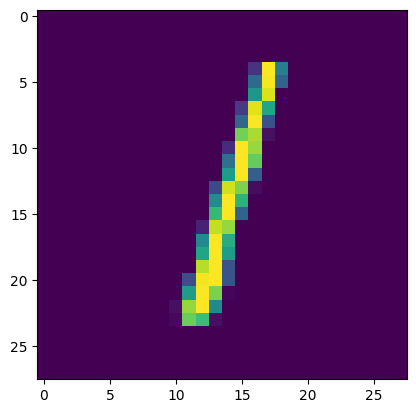

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_test_subset[2])

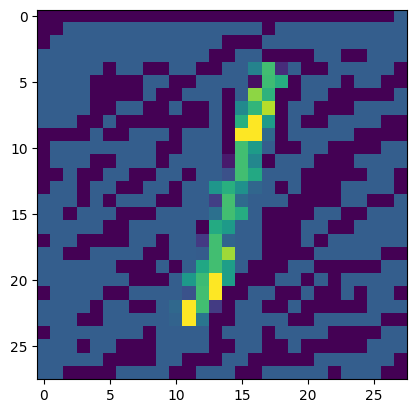

In [ ]:
plt.imshow(adversarial_examples[2].numpy()[0])

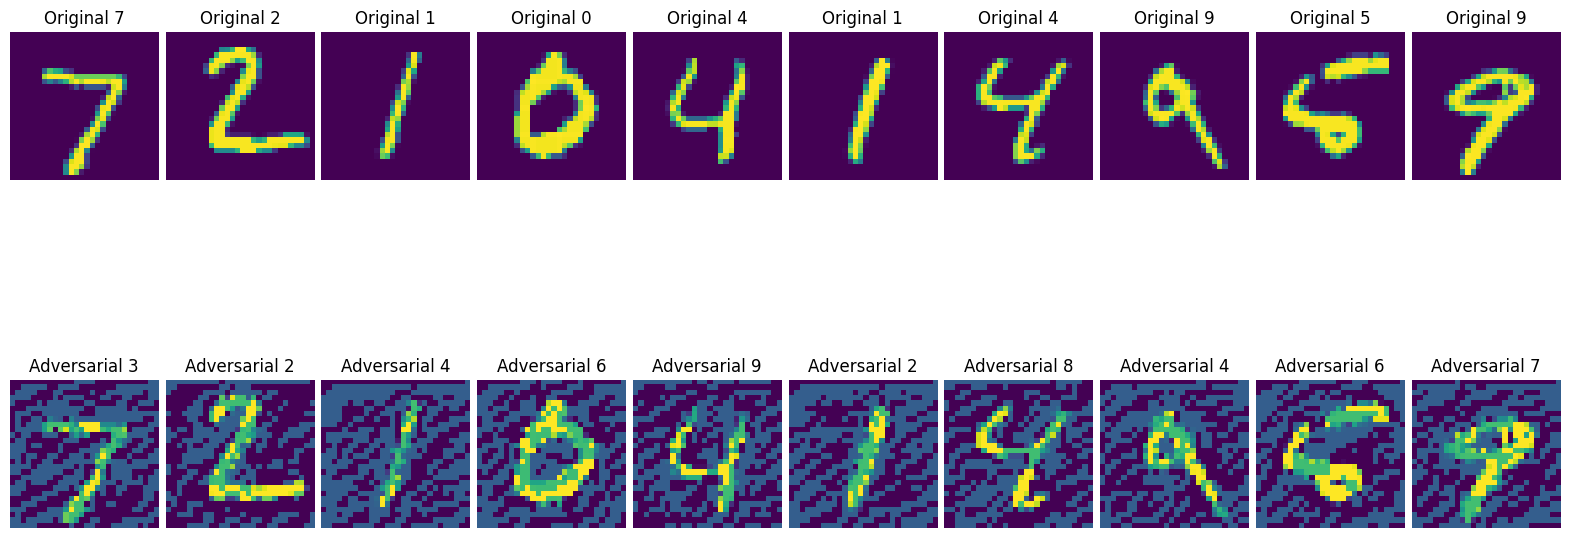

In [ ]:
fig, ax = plt.subplots(2, 10, figsize=(20, 8))
for i in range(10):
    ax[0, i].imshow(x_test_subset[i])
    ax[0, i].set_title(f"Original {np.argmax(right_predictions[i])}")
    ax[0, i].axis('off')

    ax[1, i].imshow(adversarial_examples[i].numpy()[0])
    ax[1, i].set_title(f"Adversarial {np.argmax(wrong_predictions_adversarial[i])}")
    ax[1, i].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.3)  # smaller gaps (you can tweak values)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score
original_accuracy = accuracy_score(y_test_subset, np.argmax(right_predictions, axis=1))
adversarial_accuracy = accuracy_score(y_test_subset, np.argmax(wrong_predictions_adversarial, axis=1))

print(f"Original Accuracy: {original_accuracy}")
print(f"Adversarial Accuracy: {adversarial_accuracy}")

Original Accuracy: 1.0
Adversarial Accuracy: 0.1


In [ ]:
def generate_results_epsilon(epsilon):
    # epsilon = 0.3 # Increased epsilon

    adversarial_examples = []

    for i in range(num_samples):
        original_image = x_test_subset[i:i+1]
        original_label = y_test_subset[i:i+1]

        # Convert numpy array to TensorFlow Tensor
        original_image_tensor = tf.convert_to_tensor(original_image, dtype=tf.float32)

        grad_sign = create_adversarial_pattern(model, original_image_tensor, original_label)

        adversarial_example = original_image + epsilon * grad_sign

        # Clip the values to ensure they are within the valid range [0, 1]
        adversarial_example = tf.clip_by_value(adversarial_example, 0, 1)

        adversarial_examples.append(adversarial_example)

    right_predictions = model.predict(x_test_subset)

    adversarial_image_tensor = tf.stack(adversarial_examples)

    # Remove the extra dimension added by tf.stack
    adversarial_image_tensor = tf.squeeze(adversarial_image_tensor, axis=1)


    wrong_predictions_adversarial = model.predict(adversarial_image_tensor.numpy())

    fig, ax = plt.subplots(2, 10, figsize=(20, 8))
    for i in range(10):
        ax[0, i].imshow(x_test_subset[i])
        ax[0, i].set_title(f"Original {np.argmax(right_predictions[i])}")
        ax[0, i].axis('off')

        ax[1, i].imshow(adversarial_examples[i].numpy()[0])
        ax[1, i].set_title(f"Adversarial {np.argmax(wrong_predictions_adversarial[i])}")
        ax[1, i].axis('off')

    plt.subplots_adjust(wspace=0.05, hspace=0.3)  # smaller gaps (you can tweak values)
    plt.show()

    return (right_predictions, wrong_predictions_adversarial)


Epsilon: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


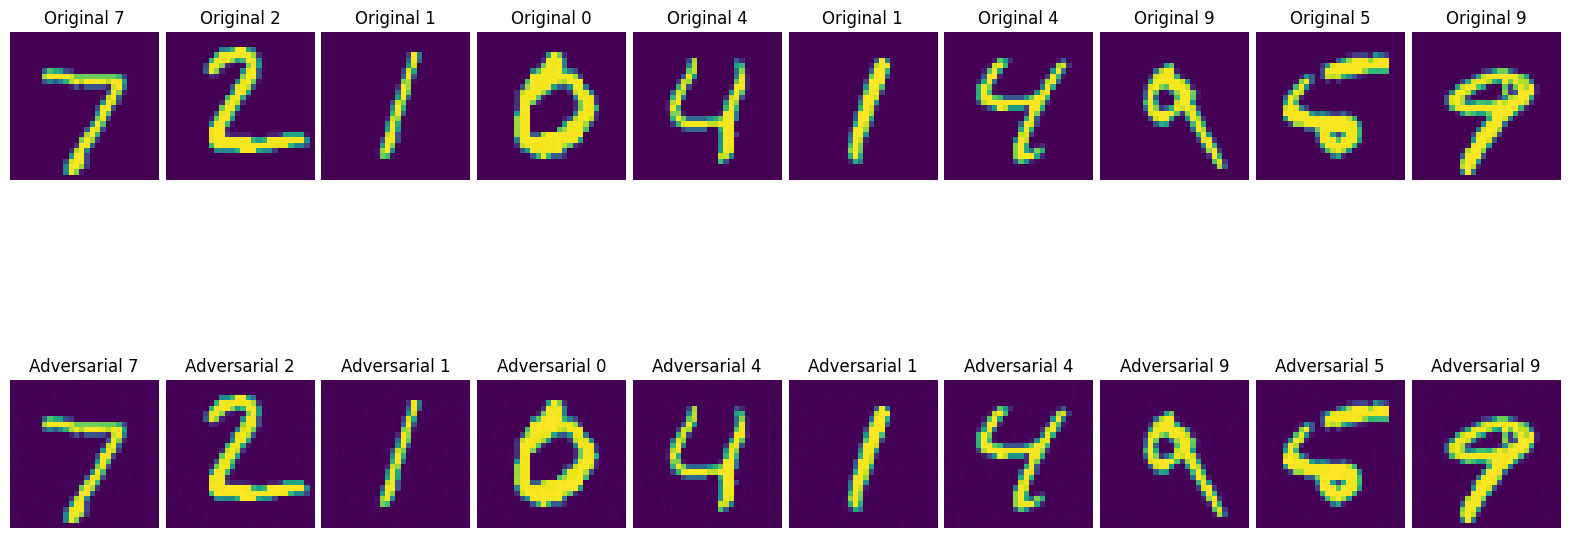

Original Accuracy: 1.0
Adversarial Accuracy: 1.0

Epsilon: 0.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


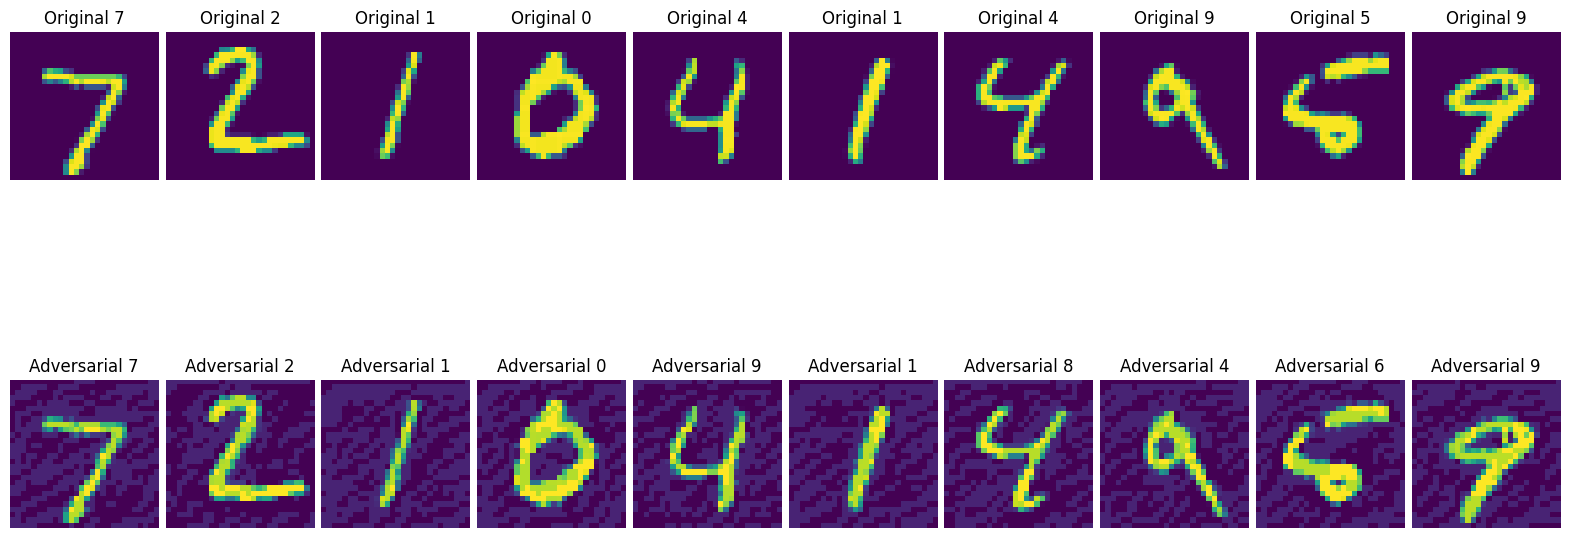

Original Accuracy: 1.0
Adversarial Accuracy: 0.6

Epsilon: 0.3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


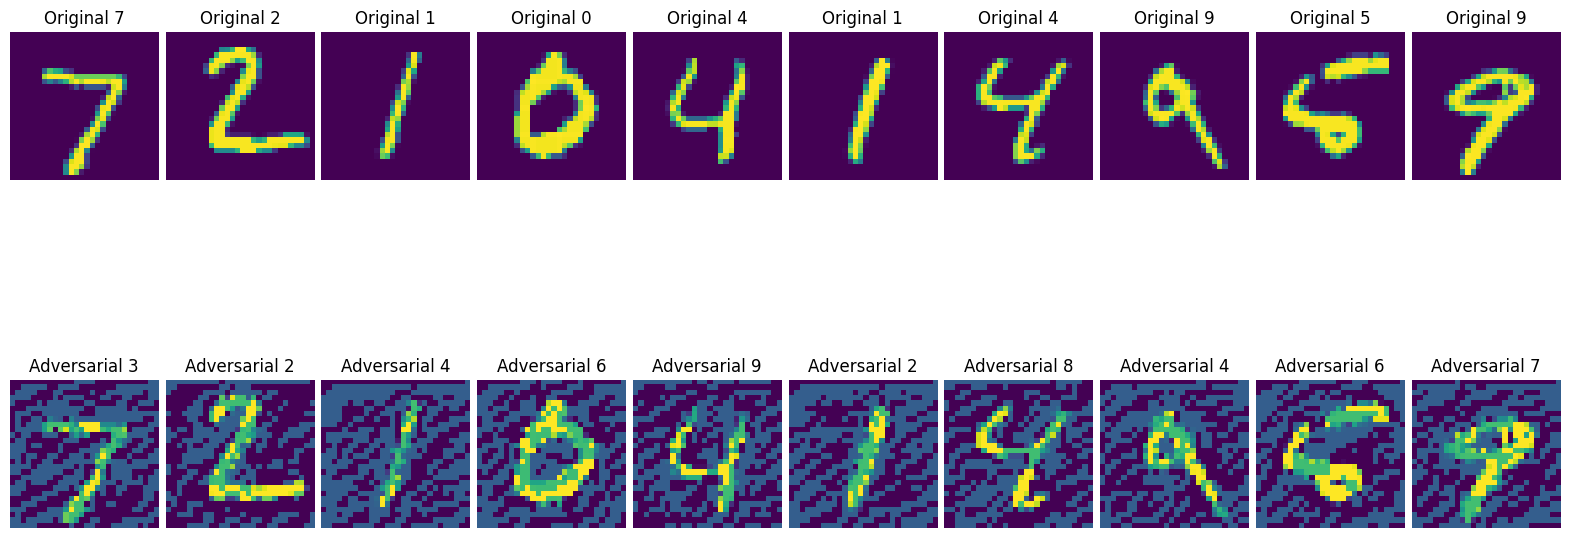

Original Accuracy: 1.0
Adversarial Accuracy: 0.1

Epsilon: 0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


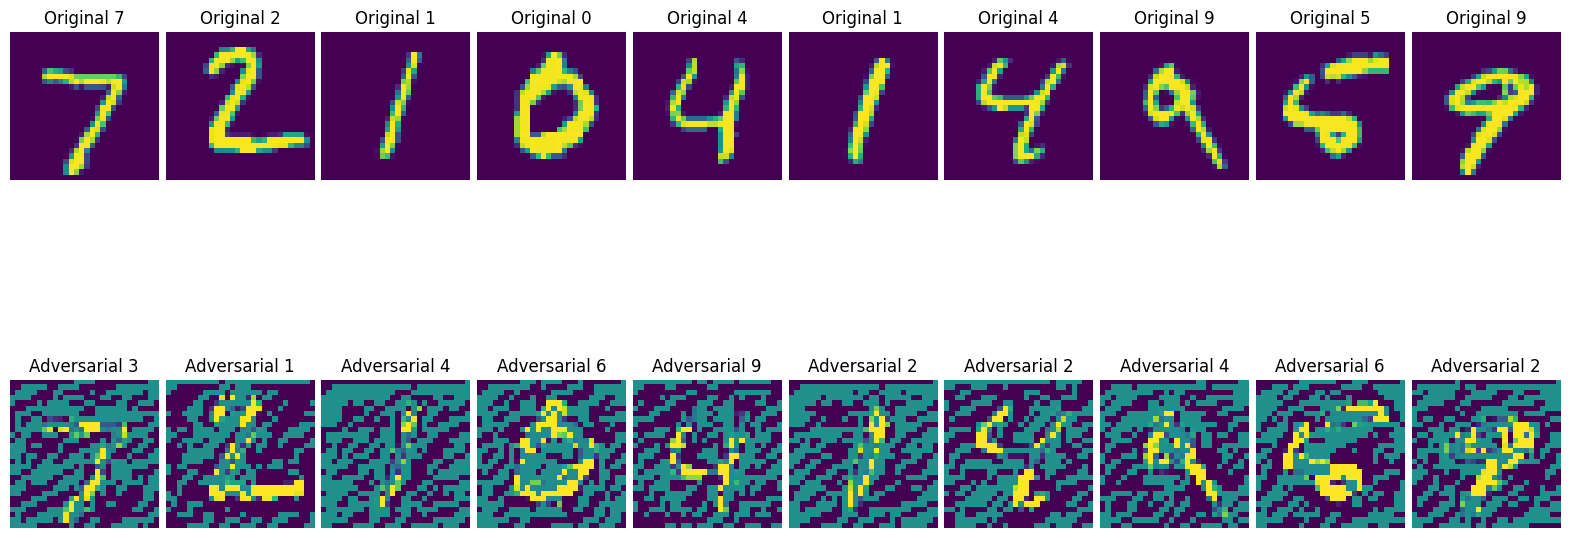

Original Accuracy: 1.0
Adversarial Accuracy: 0.0



In [ ]:
epsilon_values = [0.01, 0.1, 0.3, 0.5]

for epsilon in epsilon_values:
    print(f"Epsilon: {epsilon}")
    right_predictions, adversarial_predictions = generate_results_epsilon(epsilon)
    original_accuracy = accuracy_score(y_test_subset, np.argmax(right_predictions, axis=1))
    adversarial_accuracy = accuracy_score(y_test_subset, np.argmax(adversarial_predictions, axis=1))
    print(f"Original Accuracy: {original_accuracy}")
    print(f"Adversarial Accuracy: {adversarial_accuracy}")
    print()